In [2]:
import pandas as pd
import delicardservice as ds
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
cardNr = "123456"
password = "abcd"
ds.scrapeDelicardApi(cardNr,password)
ds.mergeDataDumps(cardNr)
data: pd.DataFrame = ds.getDataframe(cardNr)

# overview of the data
data

datum    ortName        kaName  typName   
transFullId posId                                                         
10-3419-37  1     2022-12-08 11:36:00  Cafeteria  Cafeteria 10  Verkauf  \
            2     2022-12-08 11:36:00  Cafeteria  Cafeteria 10  Verkauf   
            3     2022-12-08 11:36:00  Cafeteria  Cafeteria 10  Verkauf   
7-4003-599  1     2022-12-08 12:58:00      Mensa  Mensakasse 7  Verkauf   
            2     2022-12-08 12:58:00      Mensa  Mensakasse 7  Verkauf   
...                               ...        ...           ...      ...   
4-1001-447  4     2023-04-04 13:12:00      Mensa  Mensakasse 4  Verkauf   
7-4075-547  1     2023-04-05 13:30:00      Mensa  Mensakasse 7    Karte   
7-4075-546  1     2023-04-05 13:30:00      Mensa  Mensakasse 7  Verkauf   
            2     2023-04-05 13:30:00      Mensa  Mensakasse 7  Verkauf   
            3     2023-04-05 13:30:00      Mensa  Mensakasse 7  Verkauf   

                   zahlBetrag                          name  menge  epreis   
transFullId posId                                                            
10-3419-37  1            -3.5            Kaffee, Pfandtasse      1    1.20  \
            2            -3.5              Tassenpfand plus      1    1.00   
            3            -3.5           Brötchen mit Salami      1    1.30   
7-4003-599  1            -4.4             Stamm HK Essen 10      2    2.20   
            2            -4.4          Tafelwasser 0,3l Gl.      1    0.30   
...                       ...                           ...    ...     ...   
4-1001-447  4            -4.7          Tafelwasser 0,2l Gl.      1    0.20   
7-4075-547  1            30.0                    Aufwertung      1   30.00   
7-4075-546  1            -8.2           Aktionsessen 6,35 €      1    6.35   
            2            -8.2          Tafelwasser 0,3l Gl.      1    0.30   
            3            -8.2  Antipastibuffet Mittelteller      1    1.85   

                   gpreis  rabatt  
transFullId posId                  
10-3419-37  1        1.20     NaN  
            2        1.00     NaN  
            3        1.30     NaN  
7-4003-599  1        4.40     NaN  
            2        0.00     0.3  
...                   ...     ...  
4-1001-447  4        0.00     0.2  
7-4075-547  1       30.00     NaN  
7-4075-546  1        6.35     NaN  
            2        0.00     0.3  
            3        1.85     NaN  

[277 rows x 10 columns]

### Facts and figures

In [26]:
print(f"Verfügbarer Datenzeitraum: {data['datum'].min().date().strftime('%d.%m.%Y')} bis {data['datum'].max().date().strftime('%d.%m.%Y')}")

Verfügbarer Datenzeitraum: 08.12.2022 bis 05.04.2023


In [25]:
def convertEuro(float):
    '''Converts a number in € format.'''
    return "{:,.2f}€".format(float)

# remove balance top-ups (~ is a `not` operator)
spendings = data[~data["name"].isin(["Karte aufwerten","Aufwertung"])]

# total spendings
totalCosts = convertEuro(spendings["gpreis"].sum())
print(f"Insgesamt wurden {totalCosts} ausgegeben!")

# Show coffee and tea spendings
beveragesCosts = convertEuro(data[data["name"].str.contains("Kaffee|Tee")]["gpreis"].sum())
print(f"    - {beveragesCosts} für heiße Getränkte")

# Spendings for desserts
dessertsCosts = convertEuro(data[data["name"].str.contains("Dessert")]["gpreis"].sum())
print(f"    - {dessertsCosts} für Desserts")
joghurt = convertEuro(data[data["name"].str.contains("Stamm Dessert")]["gpreis"].sum())
print(f"       * {joghurt} für Joghurt")
sonstigeDesserts = convertEuro(data[data["name"].str.contains("Counter Dessert")]["gpreis"].sum())
print(f"       * {sonstigeDesserts} für sonstige Desserts")

# Not returned mugs
mugsPlus = data[data["name"].str.contains("Tassenpfand plus")].menge.sum()
mugsMinus = data[data["name"].str.contains("Tassenpfand minus")].menge.sum()
print("Nicht zurückgegebene Tassen:", mugsPlus - mugsMinus)


# Show spendings by facility
print("\nAusgaben nach Ort:")
mensa = spendings[["ortName", "menge", "gpreis", "rabatt"]].groupby("ortName").sum()
mensa

Insgesamt wurden 319.10€ ausgegeben!
    - 27.60€ für heiße Getränkte
    - 30.80€ für Desserts
       * 12.80€ für Joghurt
       * 18.00€ für sonstige Desserts
Nicht zurückgegebene Tassen: 0

Ausgaben nach Ort:


,menge,gpreis,rabatt
ortName,,,
Bona Vista,5,-5.00,0.0
Cafeteria,96,69.35,0.0
Mensa,156,249.65,10.9
Mensa Forum,4,5.10,0.2


### Graphs

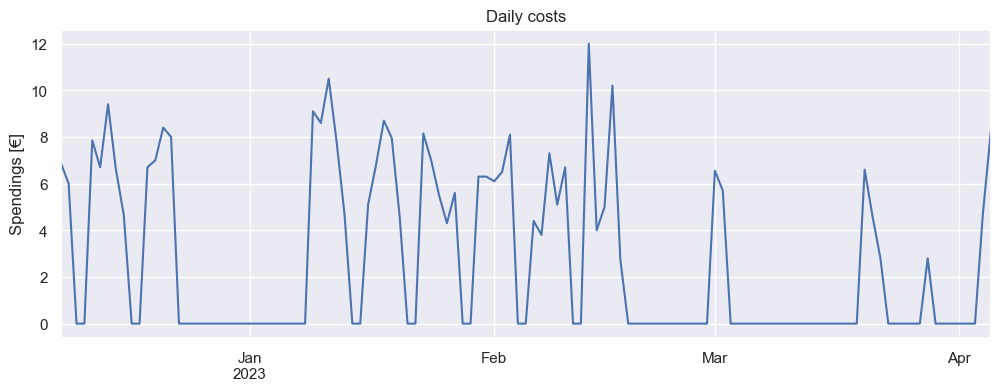

In [6]:
import matplotlib.dates as mdates
# Show graphs about total spendings per day/week
# spendings per day
dailycosts = spendings.resample("D", on="datum")["gpreis"].sum()
ax = dailycosts.plot(kind="line", figsize=(12,4), title="Daily costs", xlabel="", ylabel="Spendings [€]")

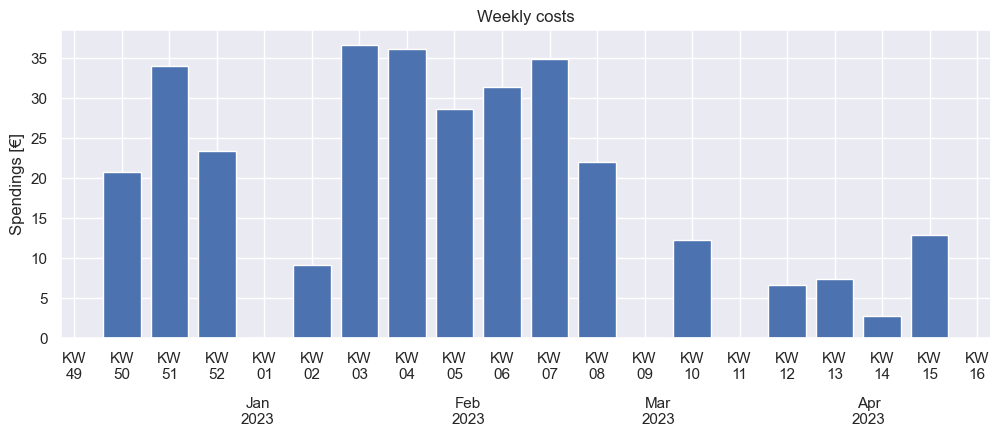

In [7]:
weeklycosts = dailycosts.resample("W-MON").sum()
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(weeklycosts.index, weeklycosts.values, width=100/len(weeklycosts.index))
ax.set(title="Weekly costs", ylabel="Spendings [€]")
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("KW\n%W"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("\n\n\n%b\n%Y"))